# Wczytanie Potrzebnych bibliotek oraz lokalizacji plików

In [1]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
import pandas as pd
import tensorflow as tf
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.models import save_model , load_model
from tensorflow.keras import layers, models
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score ,confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import imgaug.augmenters as iaa

image_folder = 'UTK_faces'
files = os.listdir(image_folder)
files.sort()
size = len(files)

# Wczytanie danych oraz agumentacja

In [2]:
images = []
ages = []
is_augmented = [] 

face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# Definicja augmentacji
augmentations = iaa.Sequential([
    iaa.Fliplr(0.5),  
    iaa.Affine(
        rotate=(-20, 20),  
        scale=(0.8, 1.2)   
    ),
    iaa.Multiply((0.8, 1.2)), 
    iaa.AdditiveGaussianNoise(scale=(0, 0.05*255)),  
])

processed_files = 0
errors = {"no_face": 0, "file_error": 0, "name_error": 0}

pbar = tqdm(files, desc="Przetwarzanie zdjęć")

for file in pbar:
    image_path = os.path.join(image_folder, file)
    image = cv2.imread(image_path, 0)
    
    if image is None:
        errors["file_error"] += 1
        pbar.set_description(f"Błąd odczytu pliku: {errors['file_error']} | Brak twarzy: {errors['no_face']} | Błąd nazwy: {errors['name_error']}")
        continue
    
    faces = face_cascade.detectMultiScale(image, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))
    
    if len(faces) == 0:
        errors["no_face"] += 1
        pbar.set_description(f"Błąd odczytu pliku: {errors['file_error']} | Brak twarzy: {errors['no_face']} | Błąd nazwy: {errors['name_error']}")
        continue
    
    try:
        split_var = file.split('_')
        age = int(split_var[0])
    except ValueError:
        errors["name_error"] += 1
        pbar.set_description(f"Błąd odczytu pliku: {errors['file_error']} | Brak twarzy: {errors['no_face']} | Błąd nazwy: {errors['name_error']}")
        continue
    
    # Wycinanie twarzy i przetwarzanie
    (x, y, w, h) = faces[0]
    face = image[y:y+h, x:x+w]
    
    face = cv2.resize(face, dsize=(128, 128))
    face = face.reshape((face.shape[0], face.shape[1], 1))  
    
    images.append(face)
    ages.append(age)
    is_augmented.append(False)
    
    # Augmentacja tylko dla osób poniżej 18 lat
    if age < 18:
        face_aug = np.expand_dims(face, axis=0)  
        augmented_faces = augmentations(images=face_aug) 
        
        for aug_face in augmented_faces:
            images.append(aug_face)
            ages.append(age)  
            is_augmented.append(True) 

    processed_files += 1

# Ostateczne podsumowanie
pbar.set_description(f"Przetwarzanie zakończone | Błędy odczytu plików: {errors['file_error']} | Brak twarzy: {errors['no_face']} | Błędy nazw: {errors['name_error']}")
print(f"Łącznie przetworzono {processed_files} plików.")
print(f"Liczba obrazów w liście: {len(images)}")


Błąd odczytu pliku: 0 | Brak twarzy: 1763 | Błąd nazwy: 0: 100%|██████████| 24108/24108 [22:38<00:00, 17.74it/s] 

Łącznie przetworzono 22345 plików.
Liczba obrazów w liście: 26202


# Wykres z podziałem na osoby pełnoletnie oraz osoby niepełnoletnie 

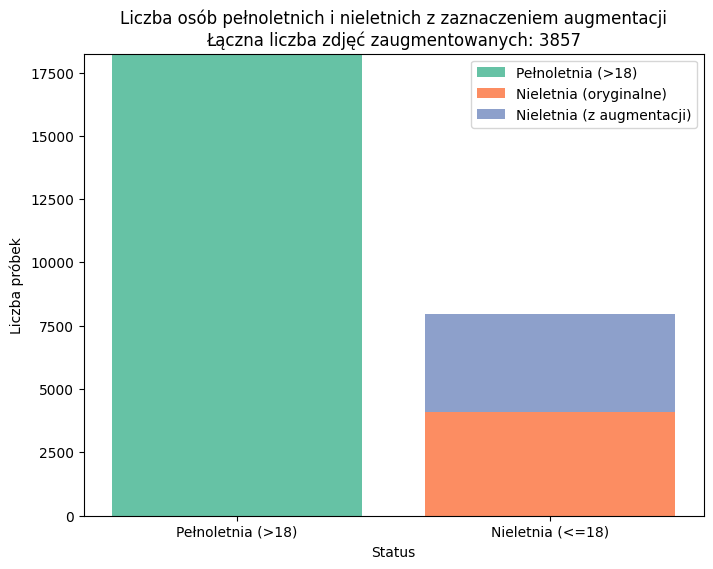

In [3]:
data = {
    'Age': ages,            
    'Is_Augmented': is_augmented 
}

df = pd.DataFrame(data)
df['Is_Adult'] = df['Age'] > 18

non_adult_count = df[(df['Age'] <= 18) & (df['Is_Augmented'] == False)].shape[0]
non_adult_augmented_count = df[(df['Age'] <= 18) & (df['Is_Augmented'] == True)].shape[0]
adult_count = df[df['Age'] > 18].shape[0]
total_augmented = df[df['Is_Augmented'] == True].shape[0]

categories = ['Pełnoletnia (>18)', 'Nieletnia (<=18)']
adult_data = [adult_count, 0] 
non_adult_data = [0, non_adult_count]  
augmented_non_adult_data = [0, non_adult_augmented_count]  

plt.figure(figsize=(8, 6))
plt.bar(categories, adult_data, color='#66c2a5', label='Pełnoletnia (>18)')
plt.bar(categories, non_adult_data, bottom=adult_data, color='#fc8d62', label='Nieletnia (oryginalne)')
plt.bar(categories, augmented_non_adult_data, bottom=[a + b for a, b in zip(adult_data, non_adult_data)], color='#8da0cb', label='Nieletnia (z augmentacji)')

plt.xlabel('Status')
plt.ylabel('Liczba próbek')
plt.title(f'Liczba osób pełnoletnich i nieletnich z zaznaczeniem augmentacji\nŁączna liczba zdjęć zaugmentowanych: {total_augmented}')
plt.legend()
plt.show()


# Przykłady zdjęć po przygotowaniu

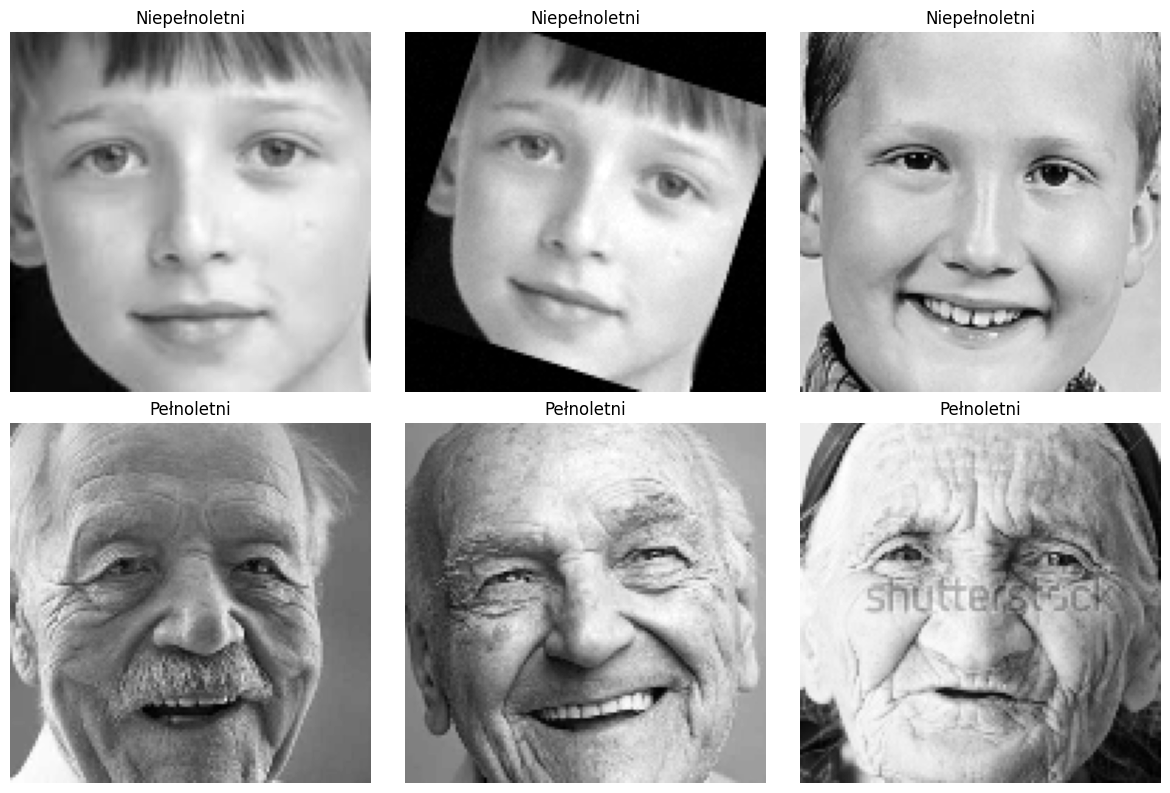

In [4]:
non_adult_selected = 0
adult_selected = 0

non_adult_images = []
adult_images = []

for i in range(len(ages)):
    if ages[i] <= 18 and non_adult_selected < 3:
        non_adult_images.append(images[i])
        non_adult_selected += 1
    elif ages[i] > 18 and adult_selected < 3:
        adult_images.append(images[i])
        adult_selected += 1
    if non_adult_selected == 3 and adult_selected == 3:
        break

selected_images = non_adult_images + adult_images

fig, axes = plt.subplots(2, 3, figsize=(12, 8))

for i, ax in enumerate(axes.flat):
    ax.imshow(selected_images[i].reshape(128, 128), cmap='gray')
    if i < 3:
        ax.set_title("Niepełnoletni")
    else:
        ax.set_title("Pełnoletni")
    ax.axis('off')

plt.tight_layout()
plt.show()

# Etykietowanie zdjęć 0 - osoba niepelnoletnia 1 - osoba pełnoletnia
## Podział na dane treningowe i testowe

In [5]:
images = np.array(images)
ages = np.array(ages)

labels = (ages > 18).astype(int)

X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

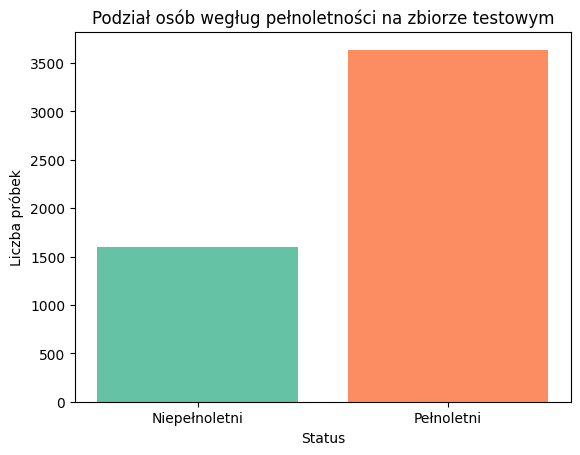

In [15]:
count_0 =  np.count_nonzero(y_test == 0)
count_1 = np.count_nonzero(y_test == 1)

kategorie = ['Niepełnoletni', 'Pełnoletni']
wartosci = [count_0, count_1]

plt.bar(kategorie, wartosci, color=['#66c2a5', '#fc8d62'])
plt.title('Podział osób wegług pełnoletności na zbiorze testowym')
plt.xlabel('Status')
plt.ylabel('Liczba próbek')
plt.show()


In [ ]:
# Jak zwalidowane (cross_validation czy inne szachermachery, test próbka - wykres i rodzaj losowania)

# Tworzenie modelu CNN oraz poprawki do niego po pierwszym przetrenowaniu

In [28]:
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 1)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(1, activation='sigmoid')  
])

model.compile(
    optimizer='adam', 
    loss='binary_crossentropy', 
    metrics=['accuracy', Precision(name='precision'), Recall(name='recall')]
)


model_corrected = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 1), kernel_regularizer=l2(0.001)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.001)),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
    layers.Dropout(0.5),  # Dodanie dropout dla redukcji przeuczenia
    layers.Dense(1, activation='sigmoid')  # Klasyfikacja binarna
])

model_corrected.compile(
    optimizer=Adam(learning_rate=0.0001),  # Zmniejszenie szybkości uczenia
    loss='binary_crossentropy', 
    metrics=['accuracy', Precision(name='precision'), Recall(name='recall')]
)

# Trenowanie modelu 

In [29]:
#history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test), batch_size=32)
history_corrected = model_corrected.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test), batch_size=32)

Epoch 1/10
656/656 [==============================] - 190s 288ms/step - loss: 0.8990 - accuracy: 0.7836 - precision: 0.7934 - recall: 0.9324 - val_loss: 0.5803 - val_accuracy: 0.8601 - val_precision: 0.8382 - val_recall: 0.9896
Epoch 2/10
656/656 [==============================] - 184s 281ms/step - loss: 0.5702 - accuracy: 0.8613 - precision: 0.8630 - recall: 0.9520 - val_loss: 0.4894 - val_accuracy: 0.9000 - val_precision: 0.8986 - val_recall: 0.9648
Epoch 3/10
656/656 [==============================] - 181s 276ms/step - loss: 0.5121 - accuracy: 0.8842 - precision: 0.8863 - recall: 0.9566 - val_loss: 0.4865 - val_accuracy: 0.8926 - val_precision: 0.9372 - val_recall: 0.9060
Epoch 4/10
656/656 [==============================] - 186s 284ms/step - loss: 0.4643 - accuracy: 0.9001 - precision: 0.8986 - recall: 0.9656 - val_loss: 0.4521 - val_accuracy: 0.9021 - val_precision: 0.9371 - val_recall: 0.9208
Epoch 5/10
656/656 [==============================] - 185s 283ms/step - loss: 0.4320 - a

# Szacowanie oraz ocena wyników na danych testowych

In [30]:
y_pred = (model_corrected.predict(X_test) > 0.5).astype(int)

164/164 [==============================] - 11s 64ms/step


In [31]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=['Niepełnoletni', 'Pełnoletni']))

Accuracy: 0.9261591299370349
               precision    recall  f1-score   support

Niepełnoletni       0.98      0.77      0.87      1603
   Pełnoletni       0.91      0.99      0.95      3638

     accuracy                           0.93      5241
    macro avg       0.94      0.88      0.91      5241
 weighted avg       0.93      0.93      0.92      5241



In [32]:
cm = confusion_matrix(y_test, y_pred)

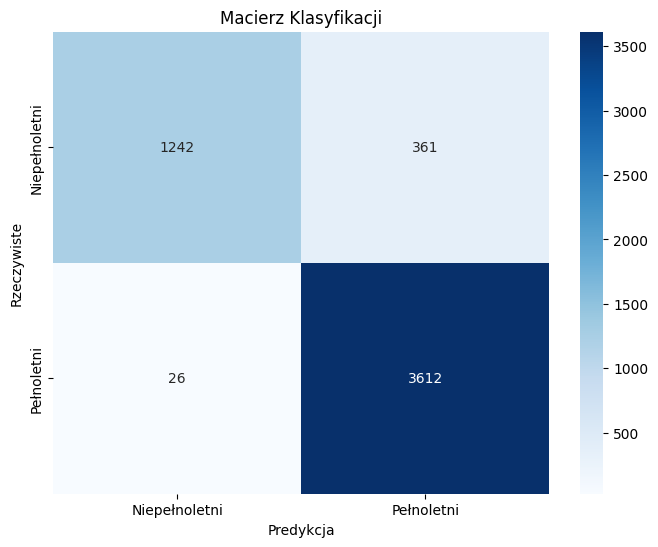

In [33]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Niepełnoletni', 'Pełnoletni'], yticklabels=['Niepełnoletni', 'Pełnoletni'])
plt.xlabel('Predykcja')
plt.ylabel('Rzeczywiste')
plt.title('Macierz Klasyfikacji')
plt.show()

164/164 [==============================] - 10s 62ms/step


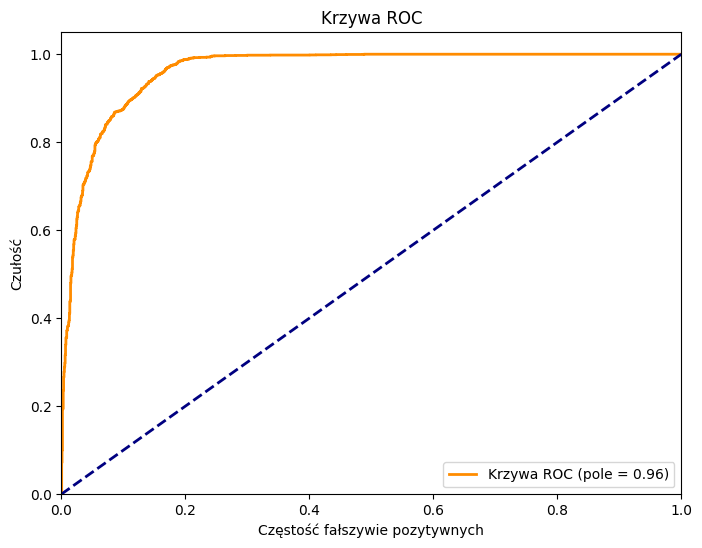

In [34]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np
# Załóżmy, że y_pred to wektor zawierający prawdopodobieństwa zwrócone przez model
y_pred = model_corrected.predict(X_test).ravel()  # Prognozy modelu
y_pred_labels = (y_pred > 0.5).astype(int)  # Konwersja prawdopodobieństw na etykiety 0 lub 1

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

# Tworzenie wykresu krzywej ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='Krzywa ROC (pole = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Częstość fałszywie pozytywnych')
plt.ylabel('Czułość')
plt.title('Krzywa ROC')
plt.legend(loc="lower right")
plt.show()

In [35]:
model.save('model_is_adult.h5')
model_corrected.save('model_is_adult_v2.h5')

# Przykład zastosowania modeli na testowych zdjęciach

In [41]:
loaded_model = load_model('model_is_adult_v2.h5')

In [72]:
def prepare_and_predict(image_path, model):
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    
    original_image = cv2.imread(image_path)
    
    if original_image is None:
        print("Błąd odczytu pliku.")
        return None, None
    
    gray_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray_image, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))
    
    if len(faces) == 0:
        print("Brak wykrytej twarzy na zdjęciu.")
        return original_image, None
    
    (x, y, w, h) = faces[0]
    face = gray_image[y:y+h, x:x+w]
   
    face = cv2.resize(face, dsize=(128, 128))
    face = face.reshape((128, 128, 1))  
    
    prediction = model.predict(np.expand_dims(face, axis=0))[0][0]
    label = "Pelnoletni" if prediction >= 0.5 else "Niepelnoletni"
    confidence = prediction if prediction >= 0.5 else 1 - prediction

   
    text = f"{label} ({confidence:.2f})"
    cv2.putText(original_image, text, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)
    cv2.rectangle(original_image, (x, y), (x+w, y+h), (0, 255, 0), 2)
    
    return original_image, prediction, label


1/1 [==============================] - 0s 21ms/step


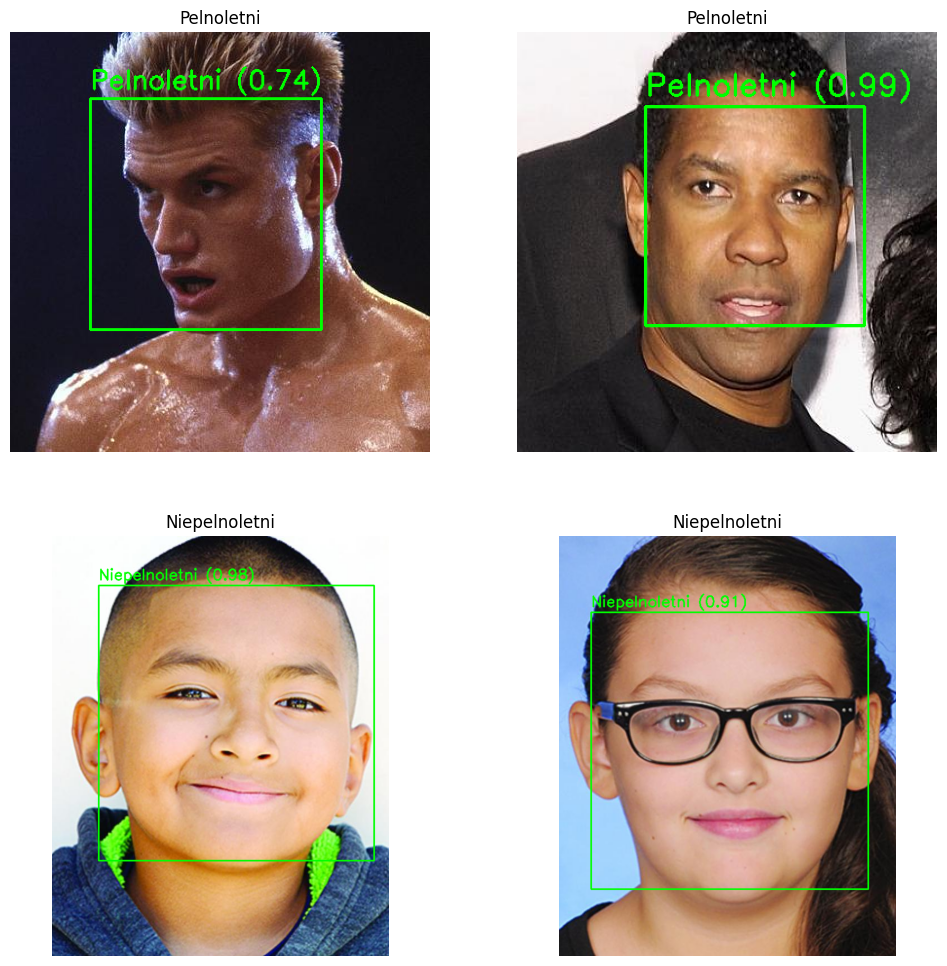

In [73]:
image_paths = [
    'Test_pictures/Test_1.jpg',
    'Test_pictures/Test_2.jpg',
    'Test_pictures/Test_3.jpg',
    'Test_pictures/Test_4.jpg'
]

predicted_images = []
labels = []

for image_path in image_paths:
    predicted_image, prediction, label = prepare_and_predict(image_path, loaded_model)
    if predicted_image is not None:
        predicted_images.append(predicted_image)
        labels.append(label)

plt.figure(figsize=(12, 12))

for i in range(len(predicted_images)):
    plt.subplot(2, 2, i + 1)  
    plt.imshow(cv2.cvtColor(predicted_images[i], cv2.COLOR_BGR2RGB))
    plt.title(labels[i])
    plt.axis('off')

plt.show()